In [1]:
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import fonctions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
import umap
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib.lines import Line2D


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder

In [2]:
#creation du fichier csv qui contient tous les tweets en faisant la somme de nobre de tweets
fichiers_csv=glob.glob(os.path.join('./sampleGraphs', "graph_*.csv"))

print(f" {len(fichiers_csv)} fichiers fusionner.")
liste_df=[]

for fichier in fichiers_csv:
        print(f"Lecture du fichier {fichier}...")
        df=pd.read_csv(fichier)
        liste_df.append(df)

df_global = pd.concat(liste_df, ignore_index=True)
df_grouped=df.groupby(['user_id', 'original_author'])['nb_retweeted'].sum().reset_index()
df_grouped.to_csv('graphe_complet_groupe.csv', index=False)
print(f"Fusion terminée. Taille finale : {len(df_grouped)} lignes.")



 9 fichiers fusionner.
Lecture du fichier ./sampleGraphs\graph_2022-01-01_to_2022-01-14.csv...
Lecture du fichier ./sampleGraphs\graph_2022-01-08_to_2022-01-21.csv...
Lecture du fichier ./sampleGraphs\graph_2022-01-15_to_2022-01-28.csv...
Lecture du fichier ./sampleGraphs\graph_2022-01-22_to_2022-02-04.csv...
Lecture du fichier ./sampleGraphs\graph_2022-01-29_to_2022-02-11.csv...
Lecture du fichier ./sampleGraphs\graph_2022-02-05_to_2022-02-18.csv...
Lecture du fichier ./sampleGraphs\graph_2022-02-12_to_2022-02-25.csv...
Lecture du fichier ./sampleGraphs\graph_2022-02-19_to_2022-03-04.csv...
Lecture du fichier ./sampleGraphs\graph_2022-02-26_to_2022-03-11.csv...
Fusion terminée. Taille finale : 53830 lignes.


In [3]:
#Creation du graphe 
G = nx.from_pandas_edgelist(df_grouped, 
                            source='user_id', 
                            target='original_author', 
                            edge_attr='nb_retweeted')



print(f"Le graphe final contient {G.number_of_nodes()} utilisateurs.")
    
    #Exploration :
node2vec=Node2Vec(G, dimensions=32, walk_length=10, num_walks=10, workers=2)

model=node2vec.fit(window=10, min_count=1, batch_words=4)

nodes =list(G.nodes)
embeddings=[model.wv[str(node)] for node in nodes]

pd_save=pd.DataFrame(embeddings, index=nodes)

pd_save.to_csv("embedings.csv")
embeddings = {str(nodes[i]): embeddings[i] for i in range(len(nodes))}

Le graphe final contient 43168 utilisateurs.


Computing transition probabilities:   0%|          | 0/43168 [00:00<?, ?it/s]

In [4]:
#lecture des deux fichier csv
#le fichier des etilisateurs tweeter
df_nodes = pd.read_csv('Nodes.csv', dtype={'Id': str})
#le fichier du resultats de l'entraînement node2vec 32 dimension (la premiere coleonne est les ids)
emb = pd.read_csv('embedings.csv') 

In [5]:
# On force la première colonne des embeddings en texte aussi
emb_col_name = emb.columns[0]
emb[emb_col_name] = emb[emb_col_name].astype(float).apply(lambda x: '{:.0f}'.format(x))

In [6]:
# 2. On crée le dictionnaire avec des clés en TEXTE
mapping_dict = {str(k): v for k, v in zip(df_nodes['Id'], df_nodes['modularity_class'])}

In [7]:
# 3. Filtrage propre , on laisse que les tweets dont on connait l'opinion , c a d l'id de l'uilisateur est dans node.csv (df_nodes)
labeled = set(df_nodes['Id'].unique())
emb_labeled = emb[emb[emb_col_name].isin(labeled)].reset_index(drop=True)

In [8]:
#la creation des des deux populations 80% pour le train , et 20% pour le test
liste_emb_filtered = emb_labeled.values.tolist()
train, test = train_test_split(liste_emb_filtered, test_size=0.20, random_state=42)

In [9]:
# On crée des versions sans la colonne ID (qui est à l'indice 0)
train_ = [row[1:] for row in train]
test_ = [row[1:] for row in test]
#apprentissage non supervisé
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

# Apprentissage sur la population de 80% avec non supervision
train_embedding = reducer.fit_transform(train_)
#le test du 20%
test_emb=reducer.transform(test_)


C:\Users\Elyes DJOUHRI\anaconda2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
#les label de chaque population 
train_opinions_np = np.array([mapping_dict.get(row[0], -1) for row in train])
test_opinions_np  = np.array([mapping_dict.get(row[0], -1) for row in test])

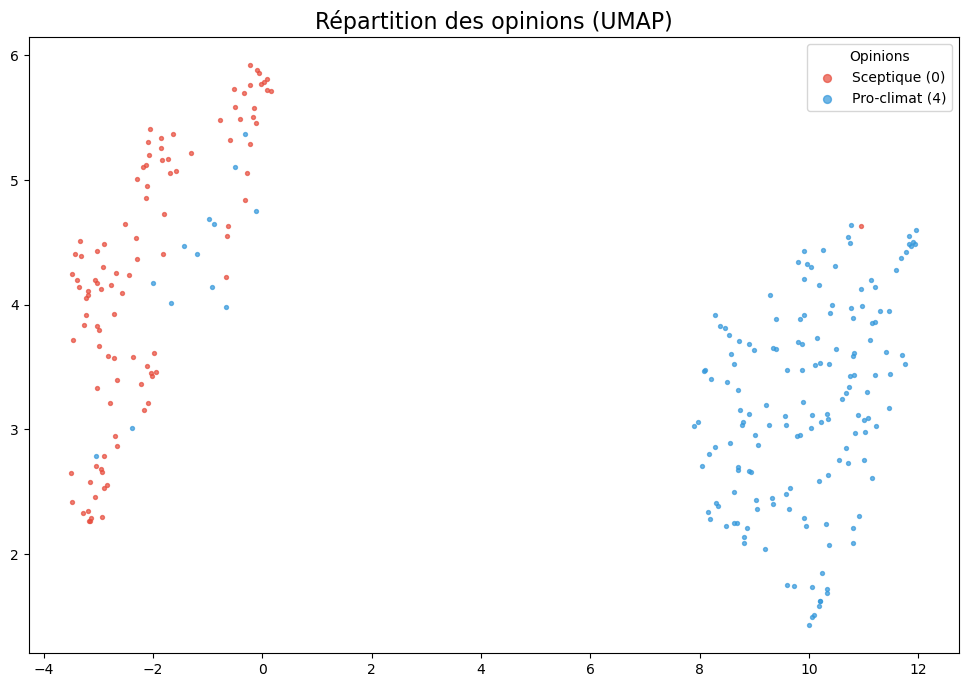

In [11]:
#le plot de train non supervisé
fonctions.plot_umap_results(train_embedding,train_opinions_np)

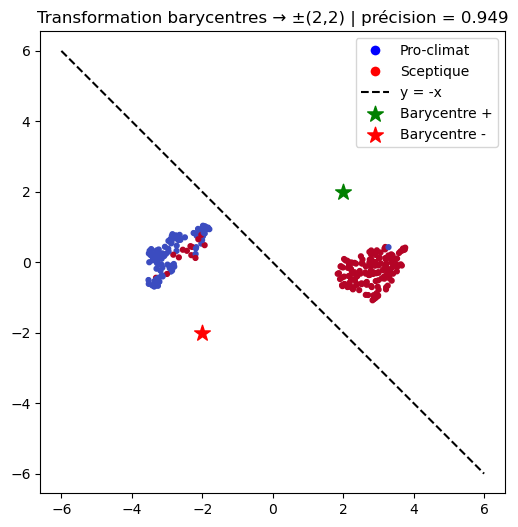

la presicion est  0.9485294117647058 



In [12]:
#calcul de presision avec les barycentre
pre_n_train=fonctions.barycenter_precision(train_embedding, train_opinions_np)
print("la presicion est ",pre_n_train,"\n")

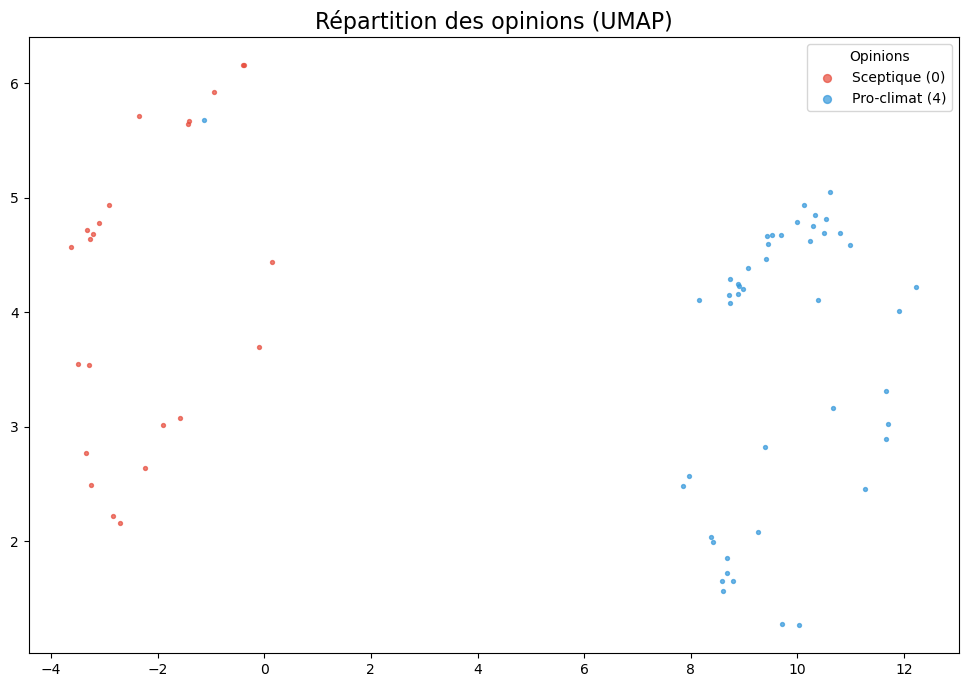

In [13]:
#le plot du test non supervisé
fonctions.plot_umap_results(test_emb,test_opinions_np)

C:\Users\Elyes DJOUHRI\anaconda2\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


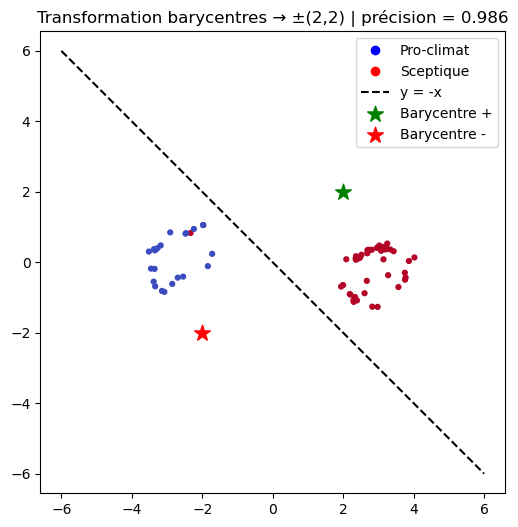

la presicion est  0.9855072463768116 



In [14]:
#calcul de presision avec les barycentre
pre_n_test=fonctions.barycenter_precision(test_emb,test_opinions_np)
print("la presicion est ",pre_n_test,"\n")

In [15]:
# Test KNN sur UMAP Non-Supervisé
knn_unsup = KNeighborsClassifier(n_neighbors=5)
knn_unsup.fit(train_embedding, train_opinions_np)
y_pred_unsup = knn_unsup.predict(test_emb)

print("--- RÉSULTATS UMAP SUPERVISÉ ---")
print(f"Accuracy: {accuracy_score(test_opinions_np, y_pred_unsup):.4f}")
print(classification_report(test_opinions_np, y_pred_unsup))

--- RÉSULTATS UMAP SUPERVISÉ ---
Accuracy: 0.9710
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           4       0.98      0.98      0.98        46

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



In [16]:
#apprentissage supervisé
reducers_sup = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    target_weight=0.5  
)
train_embedding_sup = reducers_sup.fit_transform(train_,y=train_opinions_np)
test_emb_sup=reducers_sup.transform(test_)

C:\Users\Elyes DJOUHRI\anaconda2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


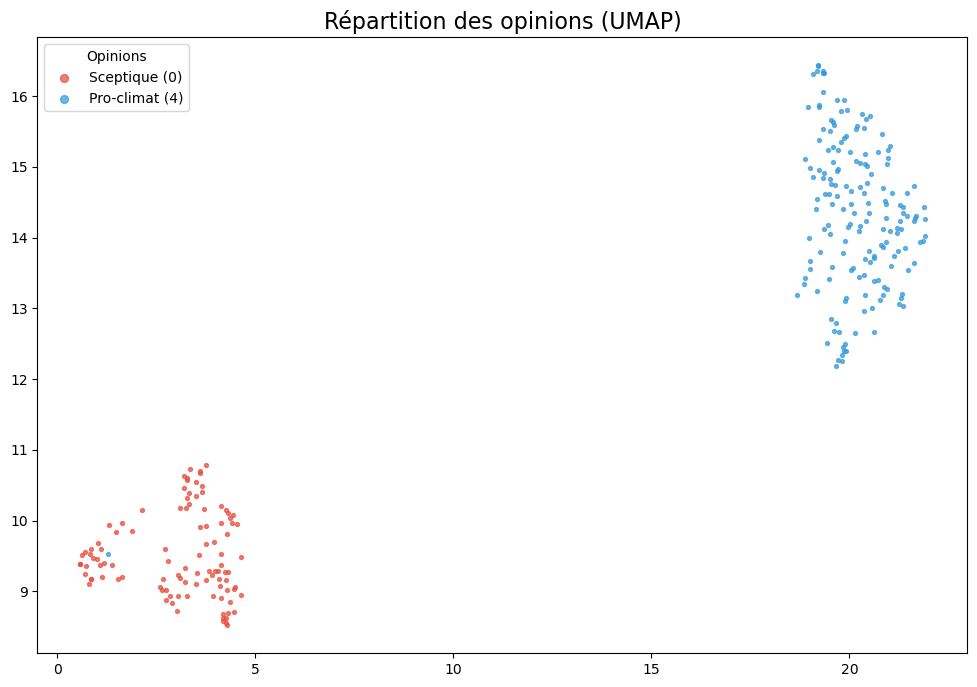

In [17]:
#le plot du train supervisé
fonctions.plot_umap_results(train_embedding_sup,train_opinions_np)

In [ ]:
def barycenter_precision(train_embedding, train_opinions_np):

    X = np.array(train_embedding)
    y = np.array(train_opinions_np)

    # Clustering
    clusters = KMeans(n_clusters=2, random_state=0, n_init=10).fit_predict(X)

    # Barycentres
    b0 = X[clusters == 0].mean(axis=0)
    b1 = X[clusters == 1].mean(axis=0)

    # Transformation affine (sans rotation)
    center = (b0 + b1) / 2
    X_centered = X - center

    dist = np.linalg.norm(b0 - b1)
    X_scaled = X_centered * (4 * np.sqrt(2) / dist)

    # Classification par y = -x
    pred_cluster = (X_scaled[:, 1] > -X_scaled[:, 0]).astype(int)

    # Sécurité : vérifier que les deux classes existent
    if len(np.unique(pred_cluster)) < 2:
        print(" Tous les points sont du même côté de y = -x")
        print("Précision forcée à 0.0")
        return 0.0

    # Association cluster a label
    def majority_label(c):
        return Counter(y[pred_cluster == c]).most_common(1)[0][0]

    label_0 = majority_label(0)
    label_1 = majority_label(1)

    y_pred = np.where(pred_cluster == 0, label_0, label_1)

    # Précision
    accuracy = np.mean(y_pred == y)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap="coolwarm", s=12)

    x = np.linspace(-6, 6, 200)
    plt.plot(x, -x, 'k--', label="y = -x")

    plt.scatter(2, 2, c='green', s=140, marker='*', label='Barycentre +')
    plt.scatter(-2, -2, c='red', s=140, marker='*', label='Barycentre -')

    # Légende personnalisée pour les labels
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Pro-climat',
               markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Sceptique',
               markerfacecolor='red', markersize=8)
    ]

    plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

    plt.title(f"Transformation barycentres → ±(2,2) | précision = {accuracy:.3f}")
    plt.axis("equal")
    plt.show()

    return accuracy

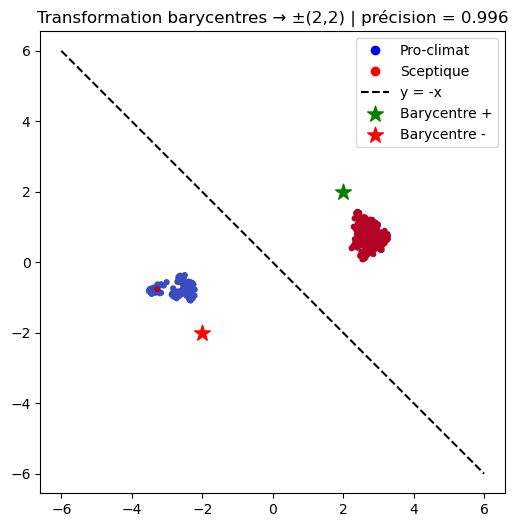

la presicion est  0.9963235294117647 



In [18]:
#calcul de presision avec les barycentre
pre_s_train=fonctions.barycenter_precision(train_embedding_sup,train_opinions_np)
print("la presicion est ",pre_s_train,"\n")

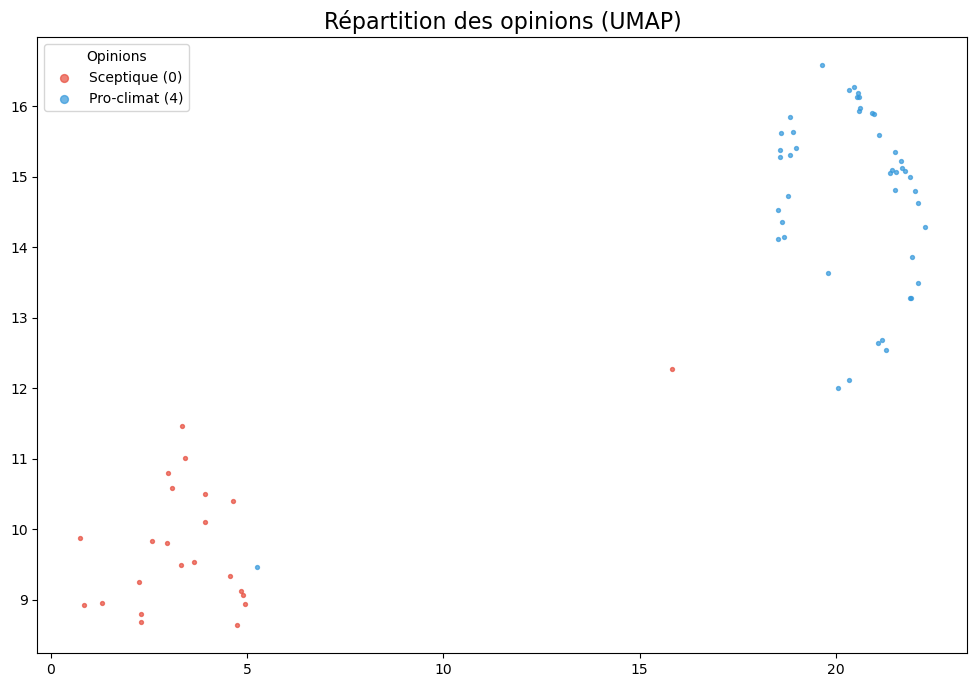

In [19]:
#le plot du test supervisé
fonctions.plot_umap_results(test_emb_sup,test_opinions_np)

C:\Users\Elyes DJOUHRI\anaconda2\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


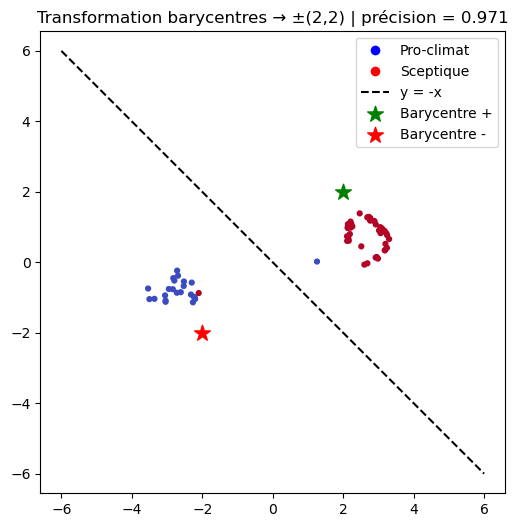

la presicion est  0.9710144927536232 



In [20]:
#calcul de presision avec les barycentre
pre_s_test=fonctions.barycenter_precision(test_emb_sup,test_opinions_np)
print("la presicion est ",pre_s_test,"\n")

In [21]:
# Test KNN sur UMAP Non-Supervisé

knn_supper=KNeighborsClassifier(n_neighbors=5)
knn_model=knn_supper.fit(train_embedding_sup,train_opinions_np)
y_pred_sup=knn_model.predict(test_emb_sup)
print(f"Précision sur les personnes connues : {accuracy_score(test_opinions_np, y_pred_sup):.2%}")


Précision sur les personnes connues : 97.10%


Classes originales : [0 4]
Classes encodées : {0, 1}
Début de l'entraînement...
Epoch 000 | Train Acc: 0.61 | Test Acc: 0.68


C:\Users\menad\AppData\Local\Temp\ipykernel_11080\1723999162.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  edge_index = torch.tensor([source, target], dtype=torch.long)


Epoch 100 | Train Acc: 0.68 | Test Acc: 0.65
Epoch 200 | Train Acc: 0.61 | Test Acc: 0.68
Epoch 300 | Train Acc: 0.64 | Test Acc: 0.72
Epoch 400 | Train Acc: 0.59 | Test Acc: 0.69
Epoch 500 | Train Acc: 0.63 | Test Acc: 0.55
Epoch 600 | Train Acc: 0.68 | Test Acc: 0.66
Epoch 700 | Train Acc: 0.68 | Test Acc: 0.66
Epoch 800 | Train Acc: 0.61 | Test Acc: 0.68
Epoch 900 | Train Acc: 0.67 | Test Acc: 0.59
Epoch 1000 | Train Acc: 0.67 | Test Acc: 0.59
Epoch 1100 | Train Acc: 0.65 | Test Acc: 0.59
Epoch 1200 | Train Acc: 0.67 | Test Acc: 0.62
Epoch 1300 | Train Acc: 0.66 | Test Acc: 0.64
Epoch 1400 | Train Acc: 0.65 | Test Acc: 0.61
Epoch 1500 | Train Acc: 0.67 | Test Acc: 0.59
Epoch 1600 | Train Acc: 0.66 | Test Acc: 0.64
Epoch 1700 | Train Acc: 0.67 | Test Acc: 0.61
Epoch 1800 | Train Acc: 0.66 | Test Acc: 0.64
Epoch 1900 | Train Acc: 0.67 | Test Acc: 0.64


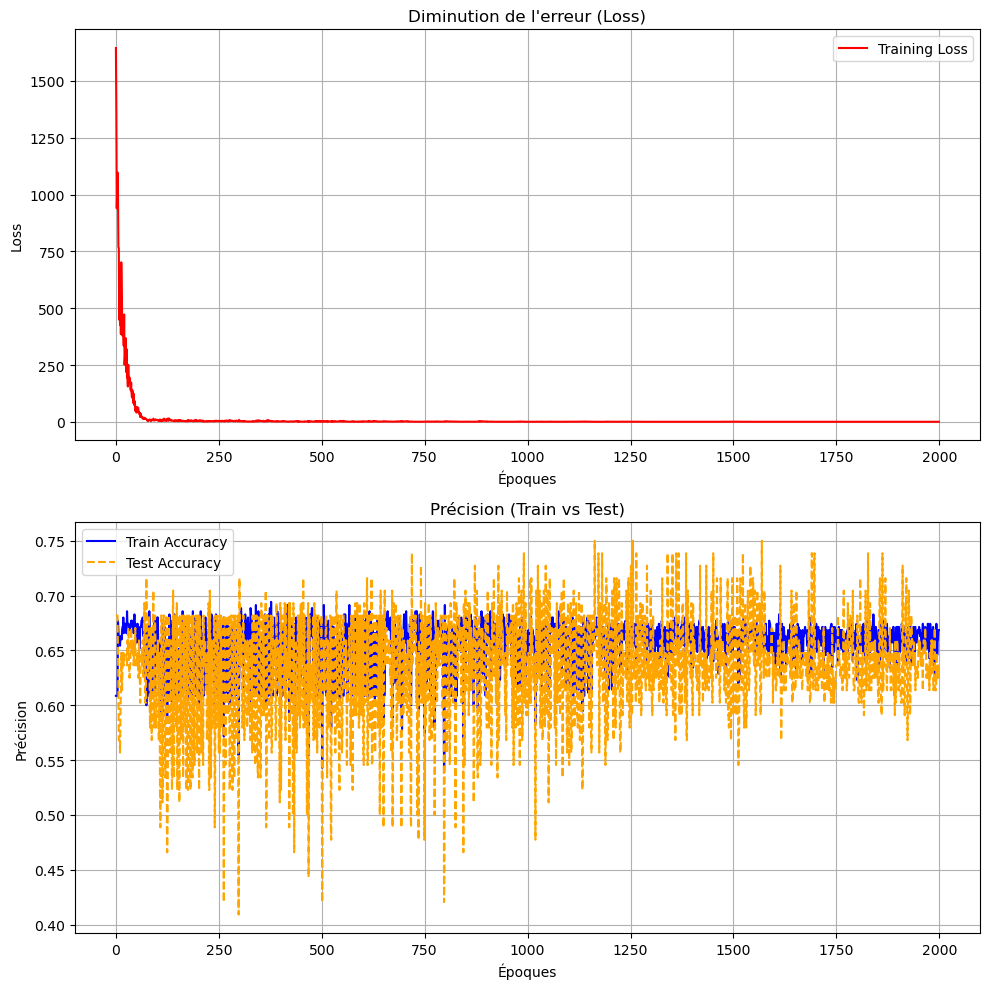

In [14]:


# -----------------------
# 0) Reproductibilité
# -----------------------
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# 1) Chargement
# -----------------------
edges_file = "graphe_complet_groupe.csv"
nodes_file = "NODES_climatoscope_graph_2022-07-01_2022-10-30_th=3.0_flc=0_world_2185-pro-anti_Louvaindic_testtop_tableusers.csv"

df_edges = pd.read_csv(edges_file)
df_nodes = pd.read_csv(nodes_file)

# -----------------------
# 2) Nettoyage / alignement
# -----------------------
node_ids_in_edges = set(df_edges["user_id"]).union(set(df_edges["original_author"]))
node_ids_in_nodes = set(df_nodes["Id"])
common_ids = list(node_ids_in_edges.intersection(node_ids_in_nodes))

df_nodes_filtered = (
    df_nodes[df_nodes["Id"].isin(common_ids)]
    .sort_values("Id")
    .reset_index(drop=True)
)

valid_ids = set(df_nodes_filtered["Id"])
df_edges_filtered = df_edges[
    df_edges["user_id"].isin(valid_ids) &
    df_edges["original_author"].isin(valid_ids)
].copy()

id_to_idx = {id_val: i for i, id_val in enumerate(df_nodes_filtered["Id"])}

# -----------------------
# 3) Features (x)
# -----------------------
feature_cols = ["nb_retweets", "nb_retweeted", "pageranks"]
df_nodes_filtered[feature_cols] = df_nodes_filtered[feature_cols].fillna(0)

x = torch.tensor(df_nodes_filtered[feature_cols].to_numpy(), dtype=torch.float)

# Normalisation simple (standardisation)
x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)

# -----------------------
# 4) Labels (y)
# -----------------------
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_nodes_filtered["modularity_class"].to_numpy())
y = torch.tensor(y_encoded, dtype=torch.long)

num_classes = len(encoder.classes_)
print("Classes originales :", encoder.classes_)
print("Classes encodées   :", set(y_encoded))

# -----------------------
# 5) Edges (edge_index) + rendre le graphe non orienté
# -----------------------
src = df_edges_filtered["user_id"].map(id_to_idx).to_numpy()
dst = df_edges_filtered["original_author"].map(id_to_idx).to_numpy()

edge_index = torch.tensor([src, dst], dtype=torch.long)

# Ajout des arêtes inverses (undirected)
edge_index_rev = torch.flip(edge_index, dims=[0])
edge_index = torch.cat([edge_index, edge_index_rev], dim=1)

data = Data(x=x, edge_index=edge_index, y=y)

# -----------------------
# 6) Split train/test (simple)
# -----------------------
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

perm = torch.randperm(data.num_nodes)
split = int(0.8 * data.num_nodes)

data.train_mask[perm[:split]] = True
data.test_mask[perm[split:]] = True

data = data.to(device)

# -----------------------
# 7) Modèle
# -----------------------
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=16, dropout_p=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden)
        self.conv2 = GCNConv(hidden, num_classes)
        self.dropout_p = dropout_p

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(num_features=data.num_features, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# -----------------------
# 8) Entraînement + historique
# -----------------------
train_losses, train_accs, test_accs = [], [], []

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()

    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)  # on réutilise 'out' calculé plus haut
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
        test_acc  = (pred[data.test_mask]  == data.y[data.test_mask]).float().mean().item()

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:04d} | Loss {loss.item():.4f} | Train {train_acc:.3f} | Test {test_acc:.3f}")

# -----------------------
# 9) Plot
# -----------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test", linestyle="--")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
